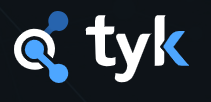

---

# **TyK Demo - Octubre 2025**

# **Conectar datos e iniciar entorno**

Como primer paso, **conectaremos nuestros datos**.

Luego, iniciaremos el entorno y sus datos **estarán listos para navegar**.



## **Conectando con sus datos**

## **Iniciar el entorno**

In [ ]:
# @title Inicializando...
!pip install pyvis
import networkx as nx
import plotly.graph_objs as go
from pyvis.network import Network
import os, re, json, csv, uuid, glob
from pathlib import Path
import tempfile
from IPython.display import display, HTML, clear_output

import matplotlib.pyplot as plt
import plotly.io as pio

from typing import Any, Dict, List, Optional, Tuple, Iterable,Union, Sequence, Set
import heapq
from collections import defaultdict
from matplotlib import cm, colormaps, colors as mcolors
import webbrowser
!pip install pycountry
# !pip install keplergl geopandas pycountry #TARDA MUCHO EN INSTALAR PERO MUESTRA EL MAPA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 61.3 MB/s eta 0:00:00



### **¿Qué debo hacer?**
- Seleccione el valor de **`DATASET`**, que indica la **carpeta donde están guardados sus archivos**.  



In [ ]:
# @title Seleccione sus datos {"run":"auto"}
import json, re, io
import pandas as pd

class TyK:
    def __init__(
        self,
        path_base: str,
        dat_folder: Optional[str] = None,
        json_bcclusters="jsonfiles/BCclusters.json",
        tex_top_clusters=None,
        tex_sub_clusters=None,
        gdf_clusters=None,

        #tex_top_clusters="texfiles/top_clusters.tex",
        #tex_sub_clusters="texfiles/subtop_clusters.tex",
        #gdf_clusters="gdffiles/BCclusters.gdf",

        json_cooc="freqs/coocnetworks.json",
    ):
        # Rutas absolutas / auto-detect con patrones
        self.path_base = path_base
        self.json_bcclusters = self._resolve_path(
            json_bcclusters, default_dir="jsonfiles",
            patterns=["*BCclusters*.json"], preferred_basename="BCclusters.json"
        )
        self.tex_top_clusters = self._resolve_path(
            tex_top_clusters, default_dir="texfiles",
            patterns=["*top_clusters*.tex"], preferred_basename="top_clusters.tex"
        )
        self.tex_sub_clusters = self._resolve_path(
            tex_sub_clusters, default_dir="texfiles",
            patterns=["*subtop_clusters*.tex"], preferred_basename="subtop_clusters.tex"
        )
        self.gdf_clusters = self._resolve_path(
            gdf_clusters, default_dir="gdffiles",
            patterns=["*BCclusters*.gdf", "*BCnetwork*.gdf"], preferred_basename="BCclusters.gdf"
        )
        self.json_cooc = self._resolve_path(
            json_cooc, default_dir="freqs",
            patterns=["*coocnetworks*.json"], preferred_basename="coocnetworks.json"
        )

        self.dat_folder = os.path.join(path_base, dat_folder) if dat_folder else None


        # Estructuras en memoria
        # --- TEX labels ---
        self.label_map_top: Dict[str, str] = {}            # "1" -> "EMPATHY"
        self.label_map_sub: Dict[str, str] = {}            # "1004" -> "PHILOSOPHY"
        self.cluster_name_to_id: Dict[str, str] = {}       # "EMPATHY" -> "1"
        self.subcluster_name_to_id: Dict[str, str] = {}    # "PHILOSOPHY" -> "1004"
        self.cluster_names: List[str] = []                 # nombres TOP
        self.subcluster_names: List[str] = []              # nombres SUB
        self.subclusters_by_top: Dict[str, List[str]] = {} # "1" -> ["1001","1002",...] se usa para listar y validar subclusters según TOP.

        # --- JSON BCclusters ---
        self.bc_clusters: Dict[str, Any] = {}
        self.cluster_dict: Dict[str, Dict[str, Any]] = {}  # "1" o "1004" -> dict completo para describe_cluster_params y _build_figure

        # --- JSON cooc ---
        self.cooc_data: Dict[str, Any] = {}

        # --- GDF ---
        self.gdf_nodes_top, self.gdf_nodes_sub = [], []
        self.gdf_edges_top, self.gdf_edges_sub = [], []


        # --- Grafos cache ---
        self.G_clusters_top: Optional[nx.Graph] = None
        self.G_sub_by_top: Dict[str, nx.Graph] = {}

        self.verbose_notify: bool = True # mostrar avisos HTML en fallbacks/casos comunes
        self.removed_clusters: Set[str] = set()
        # Títulos para stuff
        self.stuff_titles: Dict[str, str] = {
            "K": "Keywords",
            "TK": "Title Words",
            "S": "Subject Categories",
            "S2": "Subject Sub-Categories",
            "J": "Journal Sources",
            "C": "Countries",
            "I": "Institutions",
            "R": "References",
            "RJ": "Reference Sources",
            "A": "Authors (Freq)",
            "MCAU": "Most Cited Authors",
            "MCP": "Most Cited Papers",
            "MRP": "Most Representative Papers",
            "Y": "Publicaciones por año",
        }
        self.countries_global_df = None  # DF global de países (articles, frequency)
        self.cluster_summaries: Dict[str, str] = {}  # id -> HTML del resumen (top y sub)


        # =========== CARGA INICIAL ===========
        self._load_labels()            # parsea .tex si existen (puede quedar vacío)
        self._load_bcclusters_json()   # carga nodos y rellena label_real; infiere nombres si falta .tex

        self._load_cooc_json()
        self._load_gdf_clusters()
        self._index_subclusters_by_top()   # Relacionar subclusters con su top
        self._ensure_graph_from_json()
        self.countries_global_df = self._read_freq_dat(f"{path_base}freqs/freq_countries.dat")  # precalcula distribución global
        self.load_cluster_summaries(f"{path_base}clusters") #, filename="extended_bulleted_mcp.txt"


    # ------------------------ CARGA / PARSE ------------------------
    def _read_freq_dat(self, path: str) -> pd.DataFrame:
        """
        Lee un freq_countries.dat con cabeceras tipo:
        'Ranking Item Cantidad Frecuencia'
        Maneja repeticiones de encabezado y separadores irregulares.
        """
        with open(path, "r", encoding="utf-8-sig", errors="ignore") as f:
            raw = f.read()

        # Hay .dat que repiten el bloque "Ranking Item Cantidad Frecuencia"
        # y/o usan espacios variables. Normalizamos a CSV temporal.
        lines = []
        for line in raw.splitlines():
            line = line.strip()
            if not line:
                continue
            # Skip headers disfrazados o numeraciones
            if line.lower().startswith("ranking item") or line.lower().startswith("ranking, item"):
                continue
            # Separar por múltiples espacios o tab o coma
            parts = re.split(r"\s{2,}|\t|,", line)
            parts = [p.strip() for p in parts if p.strip() != ""]
            # Esperamos 4 columnas: Ranking, Item, Cantidad, Frecuencia
            if len(parts) == 4 and parts[0].isdigit():
                lines.append(parts)
            # Si ya viene sin ranking (3 cols), también lo aceptamos
            elif len(parts) == 3 and not parts[0].isdigit():
                # Item, Cantidad, Frecuencia
                lines.append(["", parts[0], parts[1], parts[2]])

        if not lines:
            raise ValueError("No pude parsear el freq_countries.dat")

        tmp = io.StringIO()
        tmp.write("ranking,item,cantidad,frecuencia\n")
        for row in lines:
            r, it, cant, freq = row
            tmp.write(f"{r},{it},{cant},{freq}\n")
        tmp.seek(0)

        df = pd.read_csv(tmp)
        # Limpieza y tipos
        df["item"] = df["item"].astype(str).str.strip()
        df["cantidad"] = pd.to_numeric(df["cantidad"], errors="coerce").fillna(0).astype(int)
        df["frecuencia"] = pd.to_numeric(df["frecuencia"], errors="coerce").fillna(0.0)

        # Ordenar por cantidad desc, luego frecuencia
        df = df.sort_values(["cantidad", "frecuencia"], ascending=[False, False]).reset_index(drop=True)

        # Renombrar al esquema estándar
        df = df.rename(columns={"item": "country", "cantidad": "articles", "frecuencia": "frequency"})
        return df[["country", "articles", "frequency"]]
    def _display_label(self, cid: str) -> str:
        cid = str(cid)
        rec = self.cluster_dict.get(cid, {}) or {}
        level = int(rec.get("level", 1) or 1)

        if level == 0:
            lab = self.label_map_top.get(cid)
        else:
            lab = self.label_map_sub.get(cid)

        lab = lab or rec.get("label_real") or rec.get("label") or cid
        return str(lab)

    def _refresh_label_indexes(self) -> None:
        """Reconstruye mapeos inversos y listas de nombres a partir de label_map_*."""
        self.cluster_name_to_id = {v: k for k, v in self.label_map_top.items() if v}
        self.subcluster_name_to_id = {v: k for k, v in self.label_map_sub.items() if v}
        self.cluster_names = list(self.cluster_name_to_id.keys())
        self.subcluster_names = list(self.subcluster_name_to_id.keys())

    def _ensure_graph_from_json(self) -> None:
        """
        Si no hay GDF cargado, usa BCclusters.json para:
          - poblar gdf_nodes_top/sub con (id,label_real,size)
          - poblar gdf_edges_top/sub con links (source,target,weight)
        Ignora aristas cruzadas TOP↔SUB. Para SUB exige mismo id_top.
        """
        if not self.cluster_dict:
            return

        # --- Nodos desde JSON si no hay GDF ---
        if not self.gdf_nodes_top and not self.gdf_nodes_sub:
            for cid, n in self.cluster_dict.items():
                if cid in self.removed_clusters:
                    continue
                cid = str(cid)
                label = n.get("label_real") or n.get("label") or cid
                size = int(n.get("size", 1))
                if int(n.get("level",0))==0:
                    self.gdf_nodes_top.append({"id": cid, "label": label, "size": size})
                else:
                    self.gdf_nodes_sub.append({"id": cid, "label": label, "size": size})
        # aristas
        if (not self.gdf_edges_top and not self.gdf_edges_sub) and self.bc_clusters.get("links"):
            for e in self.bc_clusters["links"]:
                s, t = str(e.get("source")), str(e.get("target"))
                if not s or not t or s in self.removed_clusters or t in self.removed_clusters:
                    continue
                try: w = float(e.get("weight", e.get("value", 1.0)))
                except: w = 1.0
                ns, nt = self.cluster_dict.get(s, {}), self.cluster_dict.get(t, {})
                ls, lt = int(ns.get("level",0)), int(nt.get("level",0))
                if ls==0 and lt==0:
                    self.gdf_edges_top.append({"source": s, "target": t, "weight": w})
                elif ls==1 and lt==1:
                    sid_top = str(ns.get("id_top") if ns.get("id_top") is not None else (int(s)//1000 if s.isdigit() else ""))
                    tid_top = str(nt.get("id_top") if nt.get("id_top") is not None else (int(t)//1000 if t.isdigit() else ""))
                    if sid_top == tid_top and sid_top not in self.removed_clusters:
                        self.gdf_edges_sub.append({"source": s, "target": t, "weight": w})

    def _read_text_with_fallback(self, path: str, encodings: Optional[List[str]] = None, *, errors: str = "strict") -> str:
        """
        Lee texto probando múltiples codificaciones en orden.
        Último recurso: decodifica como latin-1 con 'replace' y avisa.
        """
        encs = encodings or ["utf-8", "utf-8-sig", "latin-1", "cp1252"]
        last_err = None
        for enc in encs:
            try:
                with open(path, "r", encoding=enc, errors=errors) as f:
                    return f.read()
            except UnicodeDecodeError as e:
                last_err = e
                continue
        # último recurso: evitar crasheo
        with open(path, "rb") as f:
            raw = f.read()
        text = raw.decode("latin-1", errors="replace")
        if getattr(self, "verbose_notify", False):
            self._notify(
                f"Advertencia: decodifiqué <code>{path}</code> con fallback latin-1 (caracteres sustituidos).",
                "warn"
            )
        return text


    def _parse_labels(self, tex_paths: Union[str, os.PathLike, Sequence[Union[str, os.PathLike]]]) -> Dict[str, str]:
        """Parsea uno o varios TEX de clusters -> dict {id: nombre_real}."""
        if not tex_paths:
            return {}

        # Normalizar a lista
        if isinstance(tex_paths, (str, os.PathLike)):
            tex_paths = [tex_paths]

        labels: Dict[str, str] = {}
        for p in tex_paths:
            if not p:
                continue
            p = str(p)
            if not os.path.exists(p):
                if getattr(self, "verbose_notify", False):
                    self._notify(f"No se encontró TEX: <b>{p}</b>", "warn")
                continue

            # Ej: Cluster 1004 (``PHILOSOPHY'')
            tex = self._read_text_with_fallback(p)  # ⇐ fallback

            labels.update({m[0]: m[1] for m in re.findall(r"Cluster\s+(\d+)\s+\(``(.+?)''\)", tex)})

        return labels

    def _load_labels(self) -> None:
        """Carga labels desde TEX; si faltan, completa desde BCclusters.json."""
        # 1) Intento TEX
        self.label_map_top = self._parse_labels(self.tex_top_clusters) if self.tex_top_clusters else {}
        self.label_map_sub = self._parse_labels(self.tex_sub_clusters) if self.tex_sub_clusters else {}

        # 2) Fallback/merge con JSON si hace falta
        if self.cluster_dict:
            for cid, node in self.cluster_dict.items():
                cid = str(cid)
                lvl = int(node.get("level", 0))
                label = node.get("label_real") or node.get("label") or cid
                if lvl == 0 and cid not in self.label_map_top:
                    self.label_map_top[cid] = str(label)
                elif lvl == 1 and cid not in self.label_map_sub:
                    self.label_map_sub[cid] = str(label)

        self._refresh_label_indexes()

    def _load_bcclusters_json(self) -> None:

      """Carga BCclusters.json y completa label_real (sin borrar nodos salvo que no haya ningún label posible)."""
      self.bc_clusters, self.cluster_dict = {}, {}

      if not self.json_bcclusters or not os.path.exists(self.json_bcclusters):
          if getattr(self, "verbose_notify", False):
              self._notify("No se encontró <b>BCclusters.json</b>. Algunas funciones pueden no estar disponibles.", "warn")
          return

      with open(self.json_bcclusters, encoding="utf-8") as f:
          self.bc_clusters = json.load(f)

      nodes = self.bc_clusters.get("nodes", [])
      self.cluster_dict = {str(n.get("name") or n.get("id")): n for n in nodes}

      for cid, node in self.cluster_dict.items():
          lvl = int(node.get("level", 0))

          # Si el TEX ya definió label para este ID, lo usamos
          label_from_tex = None
          if   (lvl == 0 and cid in self.label_map_top): label_from_tex = self.label_map_top[cid]
          elif (lvl == 1 and cid in self.label_map_sub): label_from_tex = self.label_map_sub[cid]

          if label_from_tex:
              raw = label_from_tex
          else:
              raw_json = node.get("label")
              if not self._is_invalid_label(raw_json):
                  raw = str(raw_json)
              # else:
              #     # fallback desde stuff (K/TK) — si no hay nada, queda vacío
              #     raw = self._infer_label_from_stuff_minimal(node)

          label_norm = self._normalize_label_capital(raw) if raw else ""
          if not label_norm:
              # NO lo marcamos como eliminado todavía; solo vaciamos label_real.
              node["label_real"] = ""
          else:
              node["label_real"] = label_norm

      # Completar mapas desde label_real si el TEX no lo había definido
      for cid, node in self.cluster_dict.items():
          name = (node.get("label_real") or "").strip()
          if not name:
              # último recurso: ID textual (no se elimina el nodo)
              name = str(cid)
          if int(node.get("level", 0)) == 0:
              self.label_map_top.setdefault(cid, name)
          else:
              self.label_map_sub.setdefault(cid, name)

      self._refresh_label_indexes()

    def _load_cooc_json(self) -> None:
        """
        Carga la red de co-ocurrencia con tolerancia:
          - Busca coocnetworks*.json si el nombre exacto no existe
          - Soporta UTF-8 con BOM
          - Elimina comentarios // y /* ... */
          - Quita comas colgantes
          - Escapa backslashes inválidos
          - Corrige comillas dobles no escapadas dentro de cadenas:  He said "Hello" → (se quedan)  /  Cote D"Ivoire → Cote D'Ivoire
        Normaliza a {"nodes":[...], "links":[...]} aceptando alias {"N","items"} y {"E","edges"}.
        """
        self.cooc_data = {}

        # 1) Resolver ruta; aceptar variantes con sufijo (coocnetworks*.json)
        if not self.json_cooc:
            if getattr(self, "verbose_notify", False):
                self._notify("Sin <b>json_cooc</b> configurado; se omite co-ocurrencia.", "warn")
            return

        cooc_path = self.json_cooc
        if not os.path.isabs(cooc_path):
            cooc_path = os.path.join(self.path_base, cooc_path)

        if not os.path.exists(cooc_path):
            base_dir = os.path.dirname(cooc_path) or "."
            candidates = sorted(glob.glob(os.path.join(base_dir, "coocnetworks*.json")))
            if not candidates:
                if getattr(self, "verbose_notify", False):
                    self._notify(f"No se encontró <code>{self.json_cooc}</code> ni variantes <code>coocnetworks*.json</code>.", "warn")
                return
            cooc_path = candidates[0]

        # 2) Intento estricto; si falla, intento leniente con saneo
        data = self._load_json_lenient(cooc_path)
        if not data:
            # ya notificó adentro; mantenemos cooc vacía sin romper flujo
            return

        # 3) Normalizar esquema a {nodes, links}
        nodes = data.get("nodes") or data.get("N") or data.get("items") or []
        links = data.get("links") or data.get("E") or data.get("edges") or []

        norm_nodes, norm_links = [], []
        for n in nodes:
            if not isinstance(n, dict):
                continue
            nid = str(n.get("name") or n.get("id") or n.get("key") or "").strip()
            if not nid:
                continue
            norm_nodes.append({
                "name": nid,
                "item": n.get("item", n.get("label", nid)),
                "type": n.get("type", n.get("kind", "")),
                "size": int(n.get("size", n.get("count", 1)) or 1),
            })

        for e in links:
            if not isinstance(e, dict):
                continue
            s = str(e.get("source") or e.get("from") or "").strip()
            t = str(e.get("target") or e.get("to") or "").strip()
            if not s or not t:
                continue
            try:
                w = float(e.get("weight", e.get("value", 1.0)))
            except Exception:
                w = 1.0
            norm_links.append({"source": s, "target": t, "weight": w})

        if not norm_nodes or not norm_links:
            if getattr(self, "verbose_notify", False):
                self._notify(
                    f"Co-ocurrencia en <code>{cooc_path}</code> sin contenido usable "
                    f"(nodes={len(norm_nodes)}, links={len(norm_links)}).", "warn"
                )
            self.cooc_data = {}
            return

        self.cooc_data = {"nodes": norm_nodes, "links": norm_links}

    def _load_gdf_clusters(self) -> None:
      if not self.gdf_clusters or not os.path.exists(self.gdf_clusters):
          #if getattr(self, "verbose_notify", False):
             # self._notify("No se encontró <b>GDF</b>. Se usarán vistas simplificadas para los grafos.", "warn")
          return

      lines = Path(self.gdf_clusters).read_text(encoding="utf-8").splitlines()


      text = self._read_text_with_fallback(self.gdf_clusters)
      lines = text.splitlines()
      try:
          node_header_idx = next(i for i, l in enumerate(lines) if l.startswith("nodedef>"))
          edge_header_idx = next(i for i, l in enumerate(lines) if l.startswith("edgedef>"))
      except StopIteration:
          self._notify("Formato GDF inválido: faltan encabezados 'nodedef>' o 'edgedef>'.", "error")
          return

      node_header = lines[node_header_idx][len("nodedef>"):]
      node_cols = [c.strip().lower() for c in node_header.split(",")]

      def _col_idx(cands):
          for i, name in enumerate(node_cols):
              for c in cands:
                  if name.startswith(c):
                      return i
          return None

      idx_id    = _col_idx(["name", "id", "node"]) or 0
      idx_level = _col_idx(["level", "type", "group"])   # puede no existir o venir raro
      idx_size  = _col_idx(["size", "weight", "value"])

      # Limpiar estructuras previas (evita duplicados si re-ejecutás)
      self.gdf_nodes_top.clear(); self.gdf_nodes_sub.clear()
      self.gdf_edges_top.clear(); self.gdf_edges_sub.clear()

      tops_seen, subs_seen = set(), set()

      # ---- Parse nodos con prioridad: label_map -> JSON -> GDF -> heurística
      reader = csv.reader(lines[node_header_idx + 1:edge_header_idx], delimiter=",", quotechar='"')
      for r in reader:
          if not r:
              continue
          node_id = r[idx_id].strip().strip('"')
          if not node_id:
              continue

          # --- nivel
          if node_id in self.label_map_top:
              level_tag = "top"
          elif node_id in self.label_map_sub:
              level_tag = "sub"
          else:
              njson = self.cluster_dict.get(node_id)
              if njson is not None:
                  try:
                      level_tag = "sub" if int(njson.get("level", 0)) == 1 else "top"
                  except Exception:
                      level_tag = None
              else:
                  level_tag = None

              if not level_tag:
                  raw_level = (r[idx_level].strip().lower()
                              if idx_level is not None and len(r) > idx_level else "")
                  if raw_level in ("top", "sub"):
                      level_tag = raw_level
                  elif raw_level in ("0", "1"):
                      level_tag = "sub" if raw_level == "1" else "top"
                  else:
                      # heurística por ID
                      level_tag = "sub" if (node_id.isdigit() and len(node_id) >= 4) else "top"

          # --- tamaño
          size = 1
          if idx_size is not None and len(r) > idx_size:
              try:
                  size = int(float(r[idx_size]))
              except Exception:
                  size = 1
          if size == 1 and node_id in self.cluster_dict:
              try:
                  size = int(self.cluster_dict[node_id].get("size", 1))
              except Exception:
                  pass

          # --- label preferente
          if level_tag == "top":
              label = self.label_map_top.get(node_id)
          else:
              label = self.label_map_sub.get(node_id)
          if not label and node_id in self.cluster_dict:
              n = self.cluster_dict[node_id]
              label = n.get("label_real") or n.get("label")
          if not label:
              label = node_id

          # --- sin duplicar
          if level_tag == "top":
              if node_id not in tops_seen:
                  self.gdf_nodes_top.append({"id": node_id, "label": label, "size": size})
                  tops_seen.add(node_id)
          else:
              if node_id not in subs_seen:
                  self.gdf_nodes_sub.append({"id": node_id, "label": label, "size": size})
                  subs_seen.add(node_id)

      # ---- todos los TOP del label_map estén como nodos TOP
      missing_top = set(self.label_map_top.keys()) - tops_seen
      for cid in missing_top:
          n = self.cluster_dict.get(cid, {})
          label = self.label_map_top.get(cid) or n.get("label_real") or n.get("label") or cid
          try:
              size = int(n.get("size", 1))
          except Exception:
              size = 1
          self.gdf_nodes_top.append({"id": cid, "label": label, "size": size})
          tops_seen.add(cid)

      # ---- Edges
      ids_top = tops_seen
      ids_sub = subs_seen
      for line in lines[edge_header_idx + 1:]:
          if not line.strip():
              continue
          parts = [p.strip().strip('"') for p in line.split(",")]
          if len(parts) < 2:
              continue
          s, t = parts[0], parts[1]
          try:
              w = float(parts[2]) if len(parts) > 2 else 1.0
          except Exception:
              w = 1.0
          if s in ids_top and t in ids_top:
              self.gdf_edges_top.append({"source": s, "target": t, "weight": w})
          elif s in ids_sub and t in ids_sub:
              self.gdf_edges_sub.append({"source": s, "target": t, "weight": w})



    # ---------- Helpers genéricos ----------

    def _html_safe(self, s: str) -> str:
        """Escape simple + saltos de línea a <br> para mostrar en HTML."""
        if not s:
            return ""
        s = s.replace("&", "&amp;").replace("<", "&lt;").replace(">", "&gt;")
        return s.replace("\n", "<br>")

    def _shorten(self, text: str, max_chars: int = 300) -> str:
        """Devuelve un snippet breve (para tooltip)."""
        if not text:
            return ""
        t = text.strip()
        return (t[:max_chars] + "…") if len(t) > max_chars else t

    def add_cluster_summary(self, cluster_id: str, text: str) -> None:
        """Carga/actualiza el resumen para un cluster (TOP o SUB) por id."""
        cid = str(cluster_id)
        self.cluster_summaries[cid] = self._html_safe(text or "")

    def load_cluster_summaries(self, base_dir: str, filename: str = "executive_summary.txt", max_chars_per_file: int = 20000) -> int:

        import os, re

        if not base_dir or not os.path.isdir(base_dir):
            self._notify(f"Directorio no válido: <code>{base_dir}</code>", "error")
            return 0

        count = 0
        for entry in os.listdir(base_dir):
            top_path = os.path.join(base_dir, entry)
            if not os.path.isdir(top_path) or not entry.startswith("top_"):
                continue

            # id TOP
            m_top = re.search(r"top_(\d+)", entry)
            if m_top:
                tid = m_top.group(1)
                fpath = os.path.join(top_path, filename)
                if os.path.isfile(fpath):
                    try:
                        txt = open(fpath, encoding="utf-8").read()[:max_chars_per_file]
                        print("LEYENDO: ",fpath)

                        self.cluster_summaries[str(tid)] = self._html_safe(txt)
                        count += 1
                    except Exception:
                        pass

            # subclusters dentro del TOP
            for sub in os.listdir(top_path):
                sub_dir = os.path.join(top_path, sub)
                if os.path.isdir(sub_dir) and sub.startswith("subcluster_"):
                    m_sub = re.search(r"subcluster_(\d+)", sub)
                    if m_sub:
                        sid = m_sub.group(1)
                        f2 = os.path.join(sub_dir, filename)
                        if os.path.isfile(f2):
                            try:
                                txt2 = open(f2, encoding="utf-8").read()[:max_chars_per_file]
                                self.cluster_summaries[str(sid)] = self._html_safe(txt2)
                                print("LEYENDO: ",f2)

                                count += 1
                            except Exception:
                                pass

        self._notify(f"Resúmenes cargados: <b>{count}</b>", "success")
        return count

    def _is_invalid_label(self, s: Optional[str]) -> bool:
        if s is None:
            return True
        s = str(s).strip()
        if not s:
            return True
        if s in {"'", '"', "''", "“", "”", "’", "`"}:
            return True
        if re.fullmatch(r"[\W_]+", s):
            return True
        if re.match(r"(?i)^foolabel[0-9_]*$", s):
            return True
        return False

    def _normalize_label_capital(self, s: str) -> str:
        """
        Title/Capital case, preservando acrónimos:
        - en ACR_WHITELIST (p.ej. STEM)
        - de 2–3 letras (p.ej. AI, NLP, GPU, USA), opcional plural 's' o dígitos
        """
        #if self._is_invalid_label(s):
         #   return ""
        s = re.sub(r"\s+", " ", str(s).strip())

        ACR_WHITELIST = {"STEM", "ICT", "ICTS", "IoT"}
        ACR_2_3 = re.compile(r"^[A-Z]{2,3}(?:s|\d+)?$")  # AI, NLP, GPU, USA, GPUs, AI2

        def fix_token(tok: str) -> str:
            parts = tok.split("-")
            fixed = []
            for p in parts:
                if p.upper() in ACR_WHITELIST or ACR_2_3.fullmatch(p):
                    fixed.append(p.upper())
                else:
                    fixed.append(p.capitalize())
            return "-".join(fixed)

        out = s.upper()
        # out = " ".join(fix_token(t) for t in s.split(" "))
        #return "" if self._is_invalid_label(out) else out
        return out


    def _pick_best(self, paths: list, preferred_basename: Optional[str] = None) -> Optional[str]:
        if not paths:
            return None
        if preferred_basename:
            exact = [p for p in paths if os.path.basename(p).lower() == preferred_basename.lower()]
            if exact:
                return exact[0]
        # preferimos el nombre más corto (menos sufijos), luego alfabético
        return sorted(paths, key=lambda p: (len(os.path.basename(p)), os.path.basename(p)))[0]

    def _resolve_path(self,
                    given: Optional[str] = None,
                    *,
                    default_dir: str,
                    patterns: list[str],
                    preferred_basename: Optional[str] = None) -> Optional[str]:
        base = self.path_base
        # 1) Si me dieron una ruta y existe, la uso
        if given:
            p = given if os.path.isabs(given) else os.path.join(base, given)
            if os.path.exists(p):
                return p

        # 2) Buscar por patrones
        search_dir = os.path.join(base, default_dir)
        cands: list[str] = []
        for pat in patterns:
            cands.extend(glob.glob(os.path.join(search_dir, pat)))

        best = self._pick_best(cands, preferred_basename=preferred_basename)
        if best and getattr(self, "verbose_notify", False):
            self._notify(f"Usando <code>{os.path.relpath(best, base)}</code> (auto-detect).", "info")
        return best

    def _load_json_lenient(self, path: str) -> dict:
      """
      Carga JSON en dos fases con tolerancia:
        1) intenta varias codificaciones (utf-8-sig, utf-8, cp1252, latin-1)
        2) si json.loads falla, sanea el texto y reintenta.
      """
      raw = None
      for enc in ("utf-8-sig", "utf-8", "cp1252", "latin-1"):
          try:
              with open(path, "r", encoding=enc) as f:
                  raw = f.read()
              break
          except UnicodeDecodeError:
              continue

      if raw is None:
          if getattr(self, "verbose_notify", False):
              self._notify(f"No se pudo decodificar <code>{path}</code> como UTF-8/CP1252/Latin-1.", "error")
          return {}

      try:
          return json.loads(raw)
      except json.JSONDecodeError:
          pass  # seguimos al saneo

      try:
          fixed = self._sanitize_json_text(raw)
          return json.loads(fixed)
      except json.JSONDecodeError as e2:
          if getattr(self, "verbose_notify", False):
              self._notify(
                  f"JSON inválido en <code>{path}</code> (línea {e2.lineno}, col {e2.colno}). "
                  f"No fue posible sanear automáticamente."
                  f"{self._preview_error(raw, getattr(e2, 'pos', None))}",
                  "error"
              )
          return {}

    def _repair_item_strings(self, text: str) -> str:
      """
      Repara valores de "item": corrige comillas dobles internas no escapadas
      y saltos de línea dentro del string. Cierra la cadena sólo si lo que sigue
      es ',' o '}' (heurística segura para JSON).
      """
      t = text
      out = []
      i = 0
      n = len(t)
      while i < n:
          idx = t.find('"item"', i)
          if idx == -1:
              out.append(t[i:])
              break
          out.append(t[i:idx])
          i = idx
          # copia literal "item"
          out.append('"item"')
          i += len('"item"')
          # espacios y ':'
          while i < n and t[i].isspace():
              out.append(t[i]); i += 1
          if i < n and t[i] == ':':
              out.append(':'); i += 1
          while i < n and t[i].isspace():
              out.append(t[i]); i += 1

          # esperamos comilla de apertura
          if i < n and t[i] == '"':
              out.append('"'); i += 1
              buf = []
              while i < n:
                  ch = t[i]
                  # normalizar saltos de línea dentro del string
                  if ch in ('\n', '\r'):
                      buf.append(' ')
                      i += 1
                      continue
                  # comilla potencial: ¿cierre o interna?
                  if ch == '"':
                      j = i + 1
                      while j < n and t[j].isspace():
                          j += 1
                      if j < n and (t[j] == ',' or t[j] == '}'):
                          # es el cierre del valor
                          out.append(''.join(buf))
                          out.append('"')
                          i += 1
                          break
                      else:
                          # comilla interna no escapada -> convertir a '
                          buf.append("'")
                          i += 1
                          continue
                  # backslash + siguiente char: conservar tal cual
                  if ch == '\\':
                      if i + 1 < n:
                          buf.append('\\'); buf.append(t[i+1]); i += 2
                      else:
                          i += 1
                      continue
                  buf.append(ch)
                  i += 1
              else:
                  # EOF dentro del string: cerramos para no romper
                  out.append(''.join(buf))
                  out.append('"')
          # si no hay comilla, seguimos (no debería pasar)
      return ''.join(out)


    def _sanitize_json_text(self, text: str) -> str:

        t = text.replace("\r\n", "\n").replace("\ufeff", "")
        # Comentarios tipo JS
        t = re.sub(r"//[^\n]*", "", t)
        t = re.sub(r"/\*.*?\*/", "", t, flags=re.S)

        # Comas colgantes:  ,  ]   o   ,  }
        t = re.sub(r",(\s*[}\]])", r"\1", t)

        # Backslashes no válidos: \X donde X no es comilla, barra, b f n r t u
        t = re.sub(r'(?<!\\)\\(?!["\\/bfnrtu])', r'\\\\', t)

        # Comillas dobles internas no escapadas entre caracteres alfanuméricos (caso genérico tipo D"Ivoire)
        t = re.sub(r'(?<=\w)"(?=\w)', "'", t)

        # Reparación robusta de "item":"...": convierte " internas y \n/\r dentro del string
        t = self._repair_item_strings(t)

        return t


    def _preview_error(self, text: str, pos: Optional[int] = None, window: int = 120) -> str:
        """Snippet HTML alrededor de la posición del error para diagnóstico."""
        try:
            if pos is None:
                return ""
            start = max(0, pos - window)
            end = min(len(text), pos + window)
            snip = (text[start:end]
                    .replace("&", "&amp;").replace("<", "&lt;").replace(">", "&gt;"))
            return f"<pre style='white-space:pre-wrap;border:1px solid #eee;padding:6px;margin-top:6px'>{snip}</pre>"
        except Exception:
            return ""

    def _index_subclusters_by_top(self) -> None:
        self.subclusters_by_top = {}
        for cid, node in self.cluster_dict.items():
            if int(node.get("level",0)) != 1 or cid in self.removed_clusters:
                continue
            id_top = node.get("id_top")
            if id_top is None:
                try: id_top = str(int(cid)//1000)
                except: continue
            tid = str(id_top)
            if tid in self.removed_clusters:
                continue
            self.subclusters_by_top.setdefault(tid, []).append(str(cid))



    def plot_map(
        self,
        *,
        colorscale: str = "Turbo",
        height: int = 650,
        globe: bool = False,
        center_lon: float = -30.0,
        center_lat: float = 0.0,
        title: str = "<b>Countries — Global Publications Distribution</b>",
    ):

        assert self.countries_global_df is not None and not self.countries_global_df.empty

        df = self.countries_global_df.copy()
        df = df.dropna(subset=["country"])
        df["country"]  = df["country"].astype(str).str.strip()
        df["articles"] = pd.to_numeric(df["articles"], errors="coerce").fillna(0).astype(int)
        df["frequency"] = pd.to_numeric(df["frequency"], errors="coerce").fillna(0.0)


        df = (df.groupby("country", as_index=False)
                .agg(articles=("articles", "sum"),
                    frequency=("frequency", "max")))

        # % en 0–100 para colorear y para hover
        freq = df["frequency"].astype(float)
        if float(freq.max()) <= 1.0 + 1e-9:
            freq = freq * 100.0
        df["_freq100"] = freq.clip(0, 100)

        # z = frecuencia en 0–100; rango fijo para que 99.99 = extremo de la escala
        z = df["_freq100"].astype(float).to_numpy()
        zmin, zmax = 0.0, 100.0

        # Hover minimal
        hovertext = (
            "<b>" + df["country"] + "</b><br>"
            + "Artículos: " + df["articles"].map("{:,}".format) + "<br>"
            + "Frecuencia: " + df["_freq100"].map(lambda x: f"{x:.2f}%")
        )

        fig = go.Figure(
            data=go.Choropleth(
                locations=df["country"],          # SIN ISO3
                locationmode="country names",
                z=z,
                zauto=False, zmin=zmin, zmax=zmax,
                colorscale=colorscale,
                autocolorscale=False,
                text=hovertext,
                hoverinfo="text",
                marker_line_color="white",
                marker_line_width=0.6,
                showscale=True,
                colorbar=dict(title="Frecuencia (%)"),
            )
        )

        proj = "orthographic" if globe else "natural earth"
        fig.update_geos(
            showframe=False,
            showcoastlines=True,
            coastlinecolor="rgba(90,90,90,0.4)",
            projection_type=proj,
            projection_rotation=dict(lon=center_lon, lat=center_lat) if globe else None,
            showocean=True,
            oceancolor="rgba(173, 216, 230, 0.35)",
            landcolor="rgba(255,255,255,0.0)",
            bgcolor="rgba(0,0,0,0)",
            countrycolor="rgba(80,80,80,0.4)",
        )
        fig.update_layout(
            title=dict(text=title, x=0.5, xanchor="center"),
            height=height,
            margin=dict(l=0, r=0, t=60, b=0),
            hoverlabel=dict(bgcolor="white", font_size=14),
        )
        return fig


    def plot_countries_map_global(
        self,
        *,
        engine: str = "plotly",
        height: int = 650,
        colorscale: str = "Viridis",
        show_values_as_percent: bool = True,
    ):
        """
        Mapa mundial global (usando el DF precalculado en __init__).
        Más estético, con efecto hover, bordes suaves y fondo azulado.
        """
        import pandas as pd
        import plotly.graph_objects as go
        import plotly.express as px

        if self.countries_global_df is None or self.countries_global_df.empty:
            self._notify("No hay datos globales de países. Ejecutá tyk.refresh_aggregates().", "warn")
            return

        df = self.countries_global_df.copy()
        df = df.dropna(subset=["country"])
        df = df.rename(columns={"frequency": "value"})
        df["value"] = df["value"].fillna(0)

        # Resolver ISO3
        def _country_to_iso3(name: str):
            import pycountry
            aliases = {
                "United States": "USA", "United States of America": "USA",
                "UK": "GBR", "England": "GBR", "Russia": "RUS", "Iran": "IRN",
                "South Korea": "KOR", "North Korea": "PRK", "Czech Republic": "CZE",
                "Taiwan": "TWN", "Viet Nam": "VNM", "Hong Kong": "HKG",
                "Democratic Republic of the Congo": "COD", "Ivory Coast": "CIV"
            }
            name = str(name).strip()
            if name in aliases:
                return aliases[name]
            try:
                return pycountry.countries.search_fuzzy(name)[0].alpha_3
            except Exception:
                return None

        df["iso3"] = df["country"].apply(_country_to_iso3)
        df = df.dropna(subset=["iso3"])

        if df.empty:
            self._notify("No se pudieron mapear países a códigos ISO3.", "error")
            return

        # Formateo del valor en hover

        hover_text = []
        for _, r in df.iterrows():
            val = r["value"]
            arts = int(r.get("articles", 0))
            val_str = f"{int(round(float(arts)))}".replace(".", ",")

            hover_text.append(
                f"<b>{r['country']}</b><br>"
                f"{('Frecuencia: ' + f'{val:.2f}%') if show_values_as_percent else 'Valor: ' + f'{val:,}'}<br>"
                f"Artículos: {val_str}"
            )
        df["hover"] = hover_text

        # ---- Plotly choropleth con estilo mejorado ----
        fig = go.Figure(
            data=go.Choropleth(
                locations=df["iso3"],
                z=df["value"],
                text=df["hover"],
                hoverinfo="text",
                colorscale=colorscale,
                colorbar_title="Frecuencia (%)" if show_values_as_percent else "Cantidad",
                marker_line_color="white",
                marker_line_width=0.6,
                reversescale=False,
                showscale=True,
            )
        )

        fig.update_layout(
            title=dict(
                text="<b>Countries — Global Publications Distribution</b>",
                x=0.5,
                xanchor="center",
                yanchor="top",
                font=dict(size=20, color="#222"),
            ),
            geo=dict(
                showframe=False,
                showcoastlines=True,
                coastlinecolor="rgba(90,90,90,0.4)",
                projection_type="natural earth",
                showocean=True,
                oceancolor="rgba(173, 216, 230, 0.35)",
                landcolor="rgba(255,255,255,0.0)",
                bgcolor="rgba(0,0,0,0)",
                countrycolor="rgba(80,80,80,0.4)",
            ),
            height=height,
            margin=dict(l=0, r=0, t=60, b=0),
            hoverlabel=dict(
                bgcolor="white",
                font_size=14,
                font_family="Inter, sans-serif",
                font_color="#111",
            ),
        )

        # ---- Mostrar el mapa ----
        try:
            import plotly.io as pio
            pio.show(fig)
        except Exception:
            from IPython.display import HTML, display
            import plotly.io as pio
            display(HTML(pio.to_html(fig, include_plotlyjs="cdn", full_html=False)))

            #SIMPLE:
    # def plot_countries_map_global(self, *, engine: str = "plotly", height: int = 620, colorscale: str = "YlOrRd"):
    #     """
    #     Mapa mundial global (usando el DF precalculado en __init__).
    #     """
    #     if self.countries_global_df is None or self.countries_global_df.empty:
    #         self._notify("No hay datos globales de países. Intentá run: tyk.refresh_aggregates().", "warn")
    #         return
    #     df = self.countries_global_df.rename(columns={"frequency": "value"})
    #     self._plot_countries_from_df(df, title="Countries — Global", engine=engine, colorscale=colorscale, height=height)

    # ------------------------ API PÚBLICA ------------------------

    def list_clusters(self, top: bool = True, show: bool = True):
        """Devuelve [(id, nombre)] y, si show=True, renderiza una tabla amigable."""
        keyer = lambda x: (0, int(x)) if str(x).isdigit() else (1, str(x))
        removed = getattr(self, "removed_clusters", set())

        if top:
            ids = [cid for cid in self.label_map_top if cid not in removed]
            pairs = [(cid, self._normalize_label_capital(self.label_map_top[cid])) for cid in sorted(ids, key=keyer)]
            if show:
                return self._render_clusters_table(pairs, level="TOP")

            return pairs

        ids = [cid for cid in self.label_map_sub if cid not in removed]
        pairs = [(cid, self._normalize_label_capital(self.label_map_sub[cid])) for cid in sorted(ids, key=keyer)]
        if show:
            return self._render_clusters_table(pairs, level="SUB")

        return pairs


    def list_subclusters(self, top_id: str, show: bool = True):
        """Devuelve [(id_sub, nombre_sub)] del TOP dado y, si show=True, renderiza tabla."""
        tid = str(top_id)
        keyer = lambda x: (0, int(x)) if str(x).isdigit() else (1, str(x))
        removed = getattr(self, "removed_clusters", set())
        subs = [sid for sid in self.subclusters_by_top.get(tid, []) if sid not in removed]
        subs = sorted(subs, key=keyer)

        pairs = []
        for sid in subs:
            name = self._normalize_label_capital(
                self.label_map_sub.get(sid) or self.cluster_dict.get(sid, {}).get("label_real", sid)
            )
            pairs.append((sid, name))
        if show:
            return self._render_clusters_table(pairs, level="SUB", top_id=tid)
        return pairs


    # ---------- ÚNICO renderer para TOP y SUB (corrige estilo claro) ----------

    def _render_clusters_table(self, pairs: list, level: str, top_id: str = None):
        """
        Render de tabla para TOP y SUB.
        level: "TOP" | "SUB"
        top_id: si viene para SUB, no muestra la columna TOP (porque ya está filtrado).
        """
        from IPython.display import HTML, display

        if not pairs:
            if level == "TOP":
                self._notify("No hay clusters TOP disponibles.", "warn")
            else:
                if top_id:
                    self._notify(f"El TOP <b>{self.label_map_top.get(top_id, top_id)}</b> no tiene subclusters.", "warn")
                else:
                    self._notify("No hay subclusters para mostrar.", "warn")
            return

        # Encabezado y columnas según nivel
        show_top_col = (level == "SUB" and not top_id)
        if level == "TOP":
            thead = (
                "<th style='padding:10px;text-align:left'>#</th>"
                "<th style='padding:10px;text-align:left'>ID</th>"
                "<th style='padding:10px;text-align:left'>Nombre</th>"
                "<th style='padding:10px;text-align:right'>Artículos</th>"
                "<th style='padding:10px;text-align:right'>Subclusters</th>"
            )
        else:
            thead = (
                "<th style='padding:10px;text-align:left'>#</th>"
                "<th style='padding:10px;text-align:left'>ID</th>"
                "<th style='padding:10px;text-align:left'>Nombre</th>"
                "<th style='padding:10px;text-align:right'>Artículos</th>"
                + ("<th style='padding:10px;text-align:left'>TOP</th>" if show_top_col else "")
            )

        # Filas
        rows_html = []
        for i, (cid, name) in enumerate(pairs, start=1):
            c = self.cluster_dict.get(cid, {})
            size = int(c.get("size", 0))
            if level == "TOP":
                nsubs = len(self.subclusters_by_top.get(cid, []))
                extra_cells = f"<td style='padding:8px 12px; text-align:right'>{nsubs}</td>"
            else:
                top_name = ""
                if show_top_col:
                    tid = str(c.get("id_top")) if c.get("id_top") is not None else str(int(cid)//1000 if str(cid).isdigit() else "")
                    top_name = self.label_map_top.get(tid, tid)
                extra_cells = (f"<td style='padding:8px 12px'>{top_name}</td>" if show_top_col else "")

            rows_html.append(
                "<tr>"
                f"<td style='padding:8px 12px'>{i}</td>"
                f"<td style='padding:8px 12px'><code>{cid}</code></td>"
                f"<td style='padding:8px 12px'>{name}</td>"
                f"<td style='padding:8px 12px; text-align:right'>{size}</td>"
                f"{extra_cells}"
                "</tr>"
            )
        body = "".join(rows_html)

        title = (
            f"Clusters <b>TOP</b> disponibles (total: {len(pairs)})"
            if level == "TOP"
            else (
                f"Subclusters de <b>{self.label_map_top.get(top_id, top_id)}</b> (ID {top_id}) (total: {len(pairs)})"
                if top_id else f"Subclusters disponibles (total: {len(pairs)})"
            )
        )

        # Estilos: alto contraste (texto #222), fondo blanco, zebra rows
        html = f"""
        <details open style="margin:10px 0">
          <summary style="cursor:pointer; font-family:sans-serif">{title}</summary>
          <div style="margin-top:10px; max-width:1100px;">
            <table style="width:100%; border-collapse:collapse; font-family:sans-serif; background:#ffffff; color:#222;
                          border:1px solid #d7dbe2;">
              <thead style="background:#eef2f7; color:#222; border-bottom:1px solid #d7dbe2;">
                <tr>{thead}</tr>
              </thead>
              <tbody>
                {body}
              </tbody>
            </table>
          </div>
        </details>
        <style>
          details table tbody tr:nth-child(odd)  {{ background:#fafbfe; }}
          details table tbody tr:nth-child(even) {{ background:#ffffff; }}
          details table code {{ color:#374151; background: #f3f4f6; padding:2px 6px; border-radius:4px; }}
        </style>
        """

        hint = (
            "Elegí un <b>TOP</b> por <b>ID</b> o por <b>Nombre</b> donde corresponda."
            if level == "TOP"
            else ("Elegí un <b>SUB</b> por <b>ID</b> o <b>Nombre</b> para visualizar."
                  if top_id else "Indicá primero un <b>TOP</b> para filtrar sus subclusters.")
        )
        self._notify(hint, "info")
        display(HTML(html))

    def get_cluster(self, cluster_id: str) -> Dict[str, Any]:
        c = self.cluster_dict.get(str(cluster_id))
        if not c:
            raise ValueError(f"Cluster {cluster_id} no encontrado en BCclusters.json")
        return c

    # -------- GRAFOS --------
    def _render_vis_network(
        self,
        nodes: list,
        edges: list,
        title: str = "Red interactiva",
        *,
        palette: str = "YlGnBu",     # "YlGnBu" | "rainbow" | cualquier cmap de Matplotlib
        show_colorbar: bool = True,   # muestra una leyenda tipo colorbar (min↔max)
        scaling_min: int = 8,          # tamaño mínimo de nodo (px)
        scaling_max: int = 36,          # tamaño máximo de nodo (px)  ← ¡subido!
        height_px: int = 680 ,           # alto del canvas
        mode: str = "auto",          # <-- NUEVO: "auto" | "inline" | "browser"
        outfile: Optional[str] = None,  # <-- NUEVO: ruta opcional para guardar
        open_in_browser: bool = True,    # <-- NUEVO: abrir automáticamente
        show_summary_panel: bool = False,          # <<< NUEVO
        summaries_map: Optional[Dict[str, str]] = None  # <<< NUEVO (id -> HTML)
    ) -> None:

        # --- rango para la leyenda (usar crudo si existe) ---
        vals = [float(n.get("raw", n.get("value", 1))) for n in nodes] or [1.0]

        vmin, vmax = (min(vals), max(vals))
        try:
            cmap = colormaps.get_cmap(palette)
        except Exception:
            cmap = colormaps.get_cmap("YlGnBu")

        # Gradiente CSS para la barra (coincide con el colormap)
        gradient_css = "linear-gradient(to top, " + ", ".join(
            mcolors.to_hex(cmap(i/255.0)) for i in range(256)
        ) + ")"

        # --- insertar snippet corto en 'title' (tooltip) si hay summaries
        if summaries_map:
            for n in nodes:
                nid = str(n.get("id"))
                if nid in summaries_map and not n.get("title"):
                    snippet = self._shorten(summaries_map[nid], 280)
                    # 'title' es HTML simple y lo muestra vis-network como tooltip
                    n["title"] = f"<b>{n.get('label','')}</b><br><div style='max-width:360px'>{snippet}</div>"

        div_id = f"vis_{uuid.uuid4().hex}"
        panel_id = f"panel_{uuid.uuid4().hex}"

        # --- Opciones de vis-network (JSON válido) ---

        options_json = f"""
            {{
              "physics": {{
                "enabled": true,
                "solver": "barnesHut",
                "barnesHut": {{
                  "gravitationalConstant": -25000,
                  "springLength": 180,
                  "springConstant": 0.03,
                  "damping": 0.85,
                  "avoidOverlap": 0.3
                }},
                "minVelocity": 0.75,
                "stabilization": {{ "iterations": 200 }}
              }},
              "interaction": {{ "hover": true, "dragNodes": true, "dragView": true, "zoomView": true }},
              "edges": {{
                "smooth": false,
                "color": {{ "color": "rgba(120,120,120,0.28)", "highlight": "rgba(100,100,100,0.50)" }}
              }},
              "nodes": {{
                "shape": "dot",
                "scaling": {{ "min": {scaling_min}, "max": {scaling_max} }},
                "font": {{ "face": "Inter, Arial, sans-serif", "size": 14, "color": "#233" }},
                "borderWidth": 1
              }},
              "layout": {{ "improvedLayout": true, "randomSeed": 7 }}
            }}
            """.strip()
        # --- utilidades
        def _slug(s: str) -> str:
            s = re.sub(r"\s+", "_", s.strip())
            s = re.sub(r"[^\w\-.]+", "", s)
            return s[:80] or "graph"

        def _env_is_vscode():
            return "VSCODE_PID" in os.environ  # heurística simple

        # --- Colorbar (opcional), pegado al contenedor del grafo ---
        colorbar_html = ""
        if show_colorbar:
            colorbar_html = f"""
            <div style="position:absolute; top:16px; right:16px; background:white; border:1px solid #e1e5ea;
                        border-radius:6px; padding:8px 12px; font-family:sans-serif; font-size:14px; color:#222; text-align:center;">
              <div style="font-weight:600; margin-bottom:6px;">Tamaño</div>
              <div style="margin-bottom:4px;">{int(vmax)}</div>
              <div style="width:22px; height:160px; background:{gradient_css}; border:1px solid #ccc; margin:0 auto;"></div>
              <div style="margin-top:4px;">{int(vmin)}</div>
            </div>
            """

        # panel superior de resumen (si se activa)
        panel_html = ""
        if show_summary_panel:
            panel_html = f"""
            <div id="{panel_id}" style="margin:6px 0 10px 0; padding:10px 12px; border:1px solid #d8e4ff;
                border-radius:8px; background:#f6f9ff; font-family:sans-serif; color:#123;">
              <b>Tip:</b> hacé clic en un nodo para ver el resumen aquí.
            </div>
            """

        # JS: carga vis-network + click -> muestra resumen
        nodes_json = json.dumps(nodes, ensure_ascii=False)
        edges_json = json.dumps(edges, ensure_ascii=False)
        summaries_json = json.dumps(summaries_map or {}, ensure_ascii=False)

        tooltip_html = f"""
        <div id="{div_id}_tip"
            style="position:absolute; display:none; pointer-events:none;
                    background:white; border:1px solid #ddd; border-radius:6px;
                    padding:8px 10px; box-shadow:0 2px 10px rgba(0,0,0,.12);
                    max-width:320px; z-index:3; color:#111; font-family:sans-serif; font-size:13px;">
        </div>
        """

        html = f"""
        <div style="font-family:sans-serif;margin:6px 0 10px 0;font-weight:600">{title}</div>
        {panel_html}
        <div style="position:relative;">
          <div id="{div_id}" style="width:100%; height:{height_px}px; border:1px solid #e1e5ea; border-radius:8px; background-color:white;"></div>
          {colorbar_html}
          {tooltip_html}
        </div>

        <script type="text/javascript">
        (function(){{
          function ensureVis(callback) {{
            if (window.vis && window.vis.Network) {{ callback(); return; }}
            var s = document.createElement('script');
            s.src = "https://unpkg.com/vis-network@9.1.6/dist/vis-network.min.js";
            s.onload = callback;
            document.head.appendChild(s);
            var l = document.createElement('link');
            l.rel = "stylesheet";
            l.href = "https://unpkg.com/vis-network@9.1.6/dist/vis-network.min.css";
            document.head.appendChild(l);
          }}

          ensureVis(function() {{
            var container = document.getElementById("{div_id}");
            var tip       = document.getElementById("{div_id}_tip");

            var data = {{
              nodes: new vis.DataSet({json.dumps(nodes)}),
              edges: new vis.DataSet({json.dumps(edges)})
            }};
            var options   = {options_json};
            var network   = new vis.Network(container, data, options);
            var SUMMARIES = {summaries_json};
            var panel     = document.getElementById("{panel_id}");

            // ---- CLICK: mostrar resumen en el panel ----
            network.on("click", function(params){{
              if (!panel) return;
              if (params.nodes && params.nodes.length) {{
                var nid   = String(params.nodes[0]);
                var node  = data.nodes.get(nid);
                var title = (node && node.label) ? node.label : "Cluster";
                var txt   = SUMMARIES[nid] || "<i>Sin resumen disponible.</i>";
                panel.innerHTML =
                  "<div style='font-family:sans-serif'>" +
                    "<div style='font-weight:600; margin-bottom:6px;'>" + title + "</div>" +
                    "<div style='line-height:1.45;'>" + txt + "</div>" +
                  "</div>";
              }}
            }});  // <-- ¡cerrar el handler de click!

            // ---- TOOLTIP flotante (hover) ----
            function moveTip(evt) {{
              if (!evt) return;
              var rect = container.getBoundingClientRect();
              var x = (evt.clientX - rect.left) + 14;
              var y = (evt.clientY - rect.top)  + 14;
              tip.style.left = x + "px";
              tip.style.top  = y + "px";
            }}

            network.on("hoverNode", function(params){{
              var n = data.nodes.get(params.node);
              if (n && n.title) {{
                tip.innerHTML = n.title;
                tip.style.display = "block";
              }}
            }});

            network.on("blurNode", function() {{
              tip.style.display = "none";
            }});

            network.on("dragging", function(p) {{
              if (tip.style.display === "block" && p.event && p.event.srcEvent) {{
                moveTip(p.event.srcEvent);
              }}
            }});

            network.on("pointerMove", function(p) {{
              if (tip.style.display === "block" && p.event && p.event.srcEvent) {{
                moveTip(p.event.srcEvent);
              }}
            }});

            network.once("stabilizationIterationsDone", function(){{
              network.fit({{ animation: {{ duration: 500, easing: 'easeInOutQuad' }} }});
            }});
          }});
        }})();
        </script>
        """

        def _save_and_open(_html: str):
            base_dir = self.dat_folder or self.path_base or "."
            os.makedirs(base_dir, exist_ok=True)
            name = outfile or f"{_slug(title)}.html"
            outpath = os.path.join(base_dir, name)
            with open(outpath, "w", encoding="utf-8") as f:
                f.write(_html)
            if getattr(self, "verbose_notify", False):
                self._notify(f"Grafo guardado en <code>{outpath}</code>.", "info")
            if open_in_browser:
                try:
                    webbrowser.open("file://" + os.path.abspath(outpath))
                except Exception:
                    pass

        try_inline = (mode == "inline") or (mode == "auto" and not _env_is_vscode())
        if try_inline:
            try:
                display(HTML(html))
                return
            except Exception:
                # si falla inline, caemos a archivo+browser
                _save_and_open(html)
                return

        # modo "browser" o "auto" con VS Code
        _save_and_open(html)


    def plot_clusters_graph_interactive(
        self,
        min_edge_weight: float = 0.0,
        title: str = "Grafo de Clusters (TOP)",
        mode: str = "auto",
    ) -> None:
        # --- Nodos TOP desde GDF (si hay) ---
        nodes_raw = list(self.gdf_nodes_top) if self.gdf_nodes_top else []

        # --- Unión con TOP esperados por JSON (por si el GDF trajo menos) ---
        expected_top_ids = {cid for cid, n in self.cluster_dict.items() if int(n.get("level", 0)) == 0}
        have_ids = {n["id"] for n in nodes_raw}
        missing = expected_top_ids - have_ids

        for cid in missing:
            n = self.cluster_dict.get(cid, {})
            nodes_raw.append({
                "id": cid,
                "label": self._display_label(cid),
                "size": int(n.get("size", 1) or 1),
            })

        # --- Aristas TOP (solo si hay GDF) ---
        edges_raw = [e for e in self.gdf_edges_top if float(e.get("weight", 0)) >= min_edge_weight] if self.gdf_edges_top else []

        # --- Coloreo / tamaño ---
       # --- Coloreo / tamaño ---
        cmap = colormaps.get_cmap('YlGnBu')
        sizes = [int(n.get("size", 1)) for n in nodes_raw] or [1]
        norm = mcolors.Normalize(vmin=min(sizes), vmax=max(sizes))

        nodes = []
        for n in nodes_raw:
            nid = n["id"]
            # nombre bonito (prefiere label del TEX si existe)
            # pretty_label = self._display_label(cid)

            pretty_label = self.label_map_top.get(nid) or n.get("label", nid)
            # artículos reales desde el JSON (fallback al size del nodo)
            articles = int(self.cluster_dict.get(nid, {}).get("size", n.get("size", 0) or 0))
            # valor para color/escala
            val = articles if articles else int(n.get("size", 1))
            col = mcolors.to_hex(cmap(norm(max(val, 1))))

            # tooltip HTML (vis-network usa 'title' para hover)
            title_html = (
                f"<div style='font-size:13px'>"
                f"<b>{pretty_label}</b><br>"
                f"ID: <code>{nid}</code><br>"
                f"Artículos: <b>{articles}</b>"
                f"</div>"
            )

            nodes.append({
                "id": nid,
                "label": pretty_label,
                "title": title_html,       # ← tooltip con ID + artículos
                "value": val,              # usado para tamaño visual
                "color": {
                    "background": col,
                    "border": "#334",
                    "highlight": {"background": col, "border": "#222"}
                }
            })


        edges = []
        for e in edges_raw:
            w = float(e.get("weight", 1.0))
            edges.append({"from": e["source"], "to": e["target"], "value": w, "width": max(1.0, w/2.0)})

        self._render_vis_network(nodes, edges, title=title, mode=mode, show_summary_panel=True,
          summaries_map=self.cluster_summaries)



    def plot_subclusters_graph_interactive(
        self,
        top_val: str,                    # ID o nombre del TOP
        min_edge_weight: float = 0.0,
        title: Optional[str] = None,
        mode: str = "auto",          # <-- NUEVO: "auto" | "inline" | "browser"

    ) -> None:
        """
        Subclusters interactivo para un TOP (ID o nombre), con colores por tamaño (Viridis).
        Usa aristas SUB-SUB si existen; si no, grafo estrella TOP→SUB.
        """
        tid = self._resolve_top_id(top_val)
        if not tid:
            self._notify(f"TOP <b>{top_val}</b> no encontrado (usá ID o nombre exacto).", "error")
            return

        subs = self.subclusters_by_top.get(tid, [])
        if not subs:
            self._notify(f"El TOP <b>{self.label_map_top.get(tid, tid)}</b> (ID {tid}) no tiene subclusters.", "warn")
            return

        # Datos de nodos SUB
        sizes = []
        nodes = []
        for sid in subs:
            n = self.cluster_dict.get(sid, {})
            sizes.append(int(n.get("size", 1)))

        cmap = colormaps.get_cmap('YlGnBu')
        norm = mcolors.Normalize(vmin=min(sizes), vmax=max(sizes))
        for sid in subs:
            n = self.cluster_dict.get(sid, {})
            val = int(n.get("size", 1))
            col = mcolors.to_hex(cmap(norm(val)))

            label = n.get("label_real", sid)
            nodes.append({
                "id": sid, "label": label, "title": f"{label} · tamaño: {val}",
                "value": val,
                "color": {"background": col, "border": "#334",
                          "highlight": {"background": col, "border": "#222"}}
            })

        # Aristas sub-sub si existen; si no, estrella
        edges = []
        if self.gdf_edges_sub and self.gdf_nodes_sub:
            sub_set = set(subs)
            def _top_of(sub_id: str) -> str:
                n = self.cluster_dict.get(sub_id, {})
                return str(n.get("id_top") if n.get("id_top") is not None else int(sub_id)//1000)
            for e in self.gdf_edges_sub:
                s, t = e["source"], e["target"]
                if s in sub_set and t in sub_set and _top_of(s) == tid and _top_of(t) == tid:
                    w = float(e.get("weight", 1.0))
                    if w >= min_edge_weight:
                        edges.append({"from": s, "to": t, "value": w, "width": max(1.0, w/2.0)})
        if not edges:
            center_id = f"TOP-{tid}"
            top_label = self.label_map_top.get(tid, center_id)
            # tamaño del TOP como promedio visual
            avg = max(20, int(sum(n["value"] for n in nodes) / len(nodes)))
            nodes.append({
                "id": center_id, "label": top_label, "title": top_label,
                "value": avg, "color": {"background": "#e9eef8", "border": "#334"}
            })
            for n in nodes:
                if n["id"] != center_id:
                    edges.append({"from": center_id, "to": n["id"], "value": n["value"], "width": max(1.0, n["value"]/2.0)})
            if title is None:
                title = f"Subclusters de {top_label}"

        if title is None:
            title = f"Subclusters de {self.label_map_top.get(tid, '')}"

        self._render_vis_network(nodes, edges, title=title, mode=mode, show_summary_panel=True,
          summaries_map=self.cluster_summaries)

    def plot_cooc_network_interactive(
        self,
        node_type: str = "K",
        min_node_size: int = 5,
        min_edge_weight: float = 0.0,
        title: str = "Red de co-ocurrencia",
        palette: str = "YlGnBu",
        max_nodes: int = 250,           # tope de nodos mostrados (mayores por 'size')
        topk_per_node: int = 5,         # mantiene solo las k aristas más pesadas por nodo
        node_size_range: tuple = (18, 60),  # rango visual (px) para nodos
        height_px: int = 720,
        mode: str = "auto",          #  "auto" | "inline" | "browser"

    ) -> None:
        """
        Red de co-ocurrencia interactiva (vis-network) optimizada:
          - Limita a 'max_nodes' (mantiene los más grandes).
          - Sparsifica edges: top-k más pesadas por nodo + umbral de peso.
          - Nodos más grandes (rango node_size_range).
        Renderiza HTML interactivo embebido con colorbar.
        """
        if not self.cooc_data:
            self._notify("Sin datos de co-ocurrencia cargados. No es posible graficar la red.", "warn")
            return

        # --- Filtrar nodos por tipo ---
        # print(self.cooc_data.get("nodes", []))

        nodes_raw = [n for n in self.cooc_data.get("nodes", []) if n.get("type") == node_type]
        if not nodes_raw:
            self._notify(f"No se encontraron nodos del tipo <b>{node_type}</b>.", "warn")
            return

        # --- Ordenar por size y recortar a max_nodes ---
        nodes_raw.sort(key=lambda n: int(n.get("size", 1)), reverse=True)
        nodes_raw = nodes_raw[:max(1, int(max_nodes))]
        node_ids = {str(n.get("name")) for n in nodes_raw}
        node_by_id = {str(n.get("name")): n for n in nodes_raw}

        # --- Aristas: filtrar por nodos presentes y aplicar top-k por nodo + umbral ---
        edges_dict = defaultdict(list)  # por nodo, lista (peso, vecino)
        for e in self.cooc_data.get("links", []):
            s, t = str(e.get("source")), str(e.get("target"))
            if s in node_ids and t in node_ids:
                w = float(e.get("weight", 1.0))
                if w >= float(min_edge_weight):
                    edges_dict[s].append((w, t))
                    edges_dict[t].append((w, s))

        # mantener solo las k más pesadas por nodo (sin duplicar aristas)
        kept_edges = set()
        for u, lst in edges_dict.items():
            for w, v in heapq.nlargest(int(topk_per_node), lst, key=lambda x: x[0]):
                a, b = (u, v) if u < v else (v, u)
                kept_edges.add((a, b, w))

        # --- Colormap & escalado de tamaño visual ---
        try:
            cmap = colormaps.get_cmap(palette)
        except Exception:
            cmap = colormaps.get_cmap("YlGnBu")

        sizes_raw = [int(node_by_id[nid].get("size", 1)) for nid in node_ids] or [1]
        vmin, vmax = min(sizes_raw), max(sizes_raw)
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

        def _lin(v, a0, a1, b0, b1):
            if a1 <= a0: return (b0 + b1) / 2.0
            x = (v - a0) / (a1 - a0)
            return b0 + x * (b1 - b0)

        vmin_px, vmax_px = node_size_range
        nodes = []
        for nid in node_ids:
            n = node_by_id[nid]
            label = str(n.get("item", nid))
            raw_size = int(n.get("size", 1))

            # tamaño visual en píxeles (clamp)
            vis_size = _lin(raw_size, vmin, vmax, vmin_px, vmax_px)
            vis_size = max(vmin_px, min(vmax_px, vis_size))

            color = mcolors.to_hex(cmap(norm(raw_size)))
            nodes.append({
                "id": nid,
                "label": label,
                "title": f"{label} · tamaño: {raw_size}",  # muestra el crudo (ej. 83)
                "value": vis_size,                         # tamaño visual (px)
                "raw": raw_size,                           # <-- NUEVO: valor crudo para la colorbar
                "color": {
                    "background": color,
                    "border": "#334",
                    "highlight": {"background": color, "border": "#222"}
                }
            })

        # --- Edges finales (sutiles) ---
        edges = [{"from": a, "to": b, "value": w, "width": max(1.0, w/2.5)} for a, b, w in kept_edges]

        pretty_type = self.stuff_titles.get(node_type, node_type)
        final_title = f"{title} — {pretty_type} (n={len(nodes)})"

        self._render_vis_network(
            nodes, edges, title=final_title,
            palette=palette, show_colorbar=True,
            scaling_min=int(vmin_px * 0.8), scaling_max=int(vmax_px), height_px=height_px, mode=mode
        )


    # ------------------------ DESCRIPCIÓN CLUSTER ------------------------
    def describe_cluster_params(
         self,
        level: str,                # "TOP" | "SUB"  (en Colab: @param ["TOP","SUB"])
        stuff_type: str,           # (en Colab: @param ["K","TK","S","S2","J","C","I","R","RJ","A","MCAU","MCP","MRP","Y"])
        cluster_top: str = "",     # ID o nombre TOP
        cluster_sub: str = "",     # ID o nombre SUB (dentro del TOP elegido)
        listar_max: int = 20,
    )-> None:
        """
          Modo @param minimalista para notebooks.
          * Si level=TOP y no pasás cluster_top → lista TOPs.
          * Si level=SUB, pide primero cluster_top; si no hay cluster_sub → lista los SUB de ese TOP.
          """
        lvl = (level or "TOP").upper()
        if lvl not in ("TOP", "SUB"):
          self._notify(f"Nivel inválido: <b>{level}</b>. Usá <b>TOP</b> o <b>SUB</b>.", "error")
          return

        pairs = [(cid, self.label_map_top[cid]) for cid in sorted(self.label_map_top, key=int)]
        # self._render_candidates_table("Clusters TOP disponibles", pairs, limit=listar_max)

        if lvl == "TOP":
            # Si no hay TOP elegido, listamos opciones y salimos
            if not cluster_top.strip():
                # pairs = [(cid, self.label_map_top[cid]) for cid in sorted(self.label_map_top, key=int)]
                self._render_candidates_table("Clusters TOP disponibles", pairs, limit=listar_max)
                display(HTML("<div style='margin-top:6px;color:#666'>Indique <b>cluster_top</b> (ID o nombre) para visualizar.</div>"))
                return
            # pairs = [(cid, self.label_map_top[cid]) for cid in sorted(self.label_map_top, key=int)]
            self._render_candidates_table("Clusters TOP disponibles", pairs, limit=listar_max, open=False)

            tid = self._resolve_top_id(cluster_top.strip())
            if not tid:
                display(HTML(f"<div style='color:#c00'>TOP <b>{cluster_top}</b> no encontrado.</div>"))
                return
            top_name = self.label_map_top.get(tid, tid)
            cluster = self.get_cluster(tid)



            display(HTML(
                f"<div style='font-family:sans-serif;margin:6px 0 10px 0;'>"
                f"Nivel: <b>TOP</b> &nbsp;|&nbsp; Cluster: <b>{top_name}</b> (ID: {tid}) "
                f"&nbsp;|&nbsp; Tipo: <b>{self.stuff_titles.get(stuff_type, stuff_type)}</b></div>"
            ))
            fig = self._build_figure(cluster, stuff_type)
            if fig is not None:
                self._show_figure(fig)
            return

        # === SUB ===
        if not cluster_top.strip(): # Para SUB obligamos a elegir primero un TOP (y le mostramos sus opciones)
          pairs = [(cid, self.label_map_top[cid]) for cid in sorted(self.label_map_top, key=int)]
          self._render_candidates_table("Clusters TOP disponibles", pairs, limit=listar_max)
          self._notify("Indicá <b>cluster_top</b> (ID o nombre) para visualizar.", "info")
          return

        tid = self._resolve_top_id(cluster_top.strip())
        if not tid:
          self._notify(f"TOP <b>{cluster_top}</b> no encontrado.", "error")
          return

        sub_ids = self.subclusters_by_top.get(tid, [])
        sub_pairs = [(sid, self.label_map_sub.get(sid, sid)) for sid in sorted(sub_ids, key=int)]
        self._render_candidates_table("Clusters TOP disponibles", pairs, limit=listar_max, open=False)

        if not cluster_sub.strip(): # Si todavía no se eligió SUB, listamos los de ese TOP y salimos
            pairs = [(cid, self.label_map_top[cid]) for cid in sorted(self.label_map_top, key=int)]
            self._render_candidates_table(
                f"Subclusters de TOP {self.label_map_top.get(tid, tid)} (ID {tid})",
                sub_pairs, limit=listar_max
            )
            self._notify("Indicá <b>cluster_sub</b> (ID o nombre) para visualizar.", "info")
            return



        sid = self._resolve_sub_in_top(tid, cluster_sub.strip())
        if not sid:
          self._notify(
              f"El SUB <b>{cluster_sub}</b> no existe dentro del TOP <b>{self.label_map_top.get(tid, tid)}</b> (ID {tid}).",
              "error"
          )
          return


        sub_name = self.label_map_sub.get(sid, sid)
        top_name = self.label_map_top.get(tid, tid)
        cluster = self.get_cluster(sid)
        display(HTML(
            f"<div style='font-family:sans-serif;margin:6px 0 10px 0;'>"
            f"Nivel: <b>SUB</b> &nbsp;|&nbsp; Cluster: <b>{sub_name}</b> (ID: {sid}) "
            f"&nbsp;|&nbsp; TOP: <b>{top_name}</b> (ID: {tid}) "
            f"&nbsp;|&nbsp; Tipo: <b>{self.stuff_titles.get(stuff_type, stuff_type)}</b></div>"
        ))
        fig = self._build_figure(cluster, stuff_type)
        if fig is not None:
            self._show_figure(fig)


    def _display_cluster_table(
        self,
        title: str,
        headers: List[str],
        rows: List[List[Any]],
        link_column: Optional[int] = None,
        link_prefix: Optional[str] = None
    ) -> None:
        """Arma una tabla HTML con fondo blanco y texto negro (legible en tema oscuro), con links a Scholar."""
        html = f"""
        <h3 style='text-align: left; font-family: sans-serif;'>{title}</h3>
        <div style='max-width: 1000px; margin: left; overflow-y: auto; max-height: 600px; background-color: white; border: 1px solid #ccc;'>
        <table style='width: 100%; border-collapse: collapse; font-family: sans-serif; background-color: white; color: black !important;'>
            <thead style='background-color: #e6e6e6; color: black !important;'>
                <tr>
                    {''.join(f"<th style='padding: 10px; text-align: justify; border-bottom: 1px solid #ccc; color: black !important;'>{col}</th>" for col in headers)}
                </tr>
            </thead>
            <tbody>
        """
        for row in rows:
            html += "<tr>"
            for i, col in enumerate(row):
                if link_column is not None and i == link_column:
                    query = str(col).replace(' ', '+')
                    link = f"{link_prefix}{query}"
                    html += f"<td style='padding: 8px; text-align: justify; border-bottom: 1px solid #eee; color: black !important;'><a style='color: #0645AD !important;' href='{link}' target='_blank'>{col}</a></td>"
                else:
                    html += f"<td style='padding: 8px; text-align: justify; border-bottom: 1px solid #eee; color: black !important;'>{col}</td>"
            html += "</tr>"
        html += "</tbody></table></div>"
        display(HTML(html))

    def _show_figure(self, fig: go.Figure) -> None:  #Muestra figuras de Plotly directamente (con fallback HTML si hace falta).
      try:
          pio.show(fig)
      except Exception:
          html = pio.to_html(fig, include_plotlyjs="cdn", full_html=False)
          display(HTML(html))

    def _build_figure(self, cluster_data: Dict[str, Any], stuff_type: str) -> Optional[go.Figure]:
        cid = str(cluster_data.get("name"))
        cluster_name = cluster_data.get("label_real", cluster_data.get("label", cid))
        size_val = int(cluster_data.get("size", 0))
        stuff = (cluster_data.get("stuff", {}) or {}).get(stuff_type, [])

        titles = {
            "Y": "Publicaciones por año",
            "MCP": "Artículos más citados",
            "MRP": "Artículos más representativos",
            "MCAU": "Autores más citados",
        }

        if not stuff:
          if getattr(self, "verbose_notify", False):
              self._notify(f"{cluster_name}: sin datos para <b>{self.stuff_titles.get(stuff_type, stuff_type)}</b>.", "warn")
          return go.Figure().update_layout(title=f"{cluster_name}: sin datos para {stuff_type}")


        if stuff_type == "Y": # ---------- Distribución por año ----------
            stuff = sorted(stuff, key=lambda s: int(s[0])) # asegurar orden cronológico
            labels = [int(s[0]) for s in stuff]
            values = [int(round(s[1])) for s in stuff]
            fig = go.Figure(go.Bar(x=labels, y=values, text=[f"{v}" for v in values], textposition="auto"))
            fig.update_layout(
                title=f"{cluster_name} — {titles.get('Y', 'Año')}",
                xaxis_title="Año", yaxis_title="N° artículos",
                height=max(360, 28*len(labels)),
                margin=dict(l=60, r=20, t=40, b=40),
            )
            return fig

        if stuff_type in ("MCP", "MRP"):    # ---------- Tablas: MCP / MRP ----------
            headers = ["Title", "Author(s)", "Journal (Year)", "In-degree", "Times Cited"]
            rows = []
            for item in stuff: # (title, author, journal, year, cited, indegree, doc_type)
                title = item[0] if len(item) > 0 else ""
                author = item[1] if len(item) > 1 else ""
                journal = item[2] if len(item) > 2 else ""
                year = item[3] if len(item) > 3 else ""
                cited = item[4] if len(item) > 4 else 0
                indegree = item[5] if len(item) > 5 else 0
                rows.append([title, author, f"{journal} ({year})", indegree, cited])

            pretty = "Most Representative Papers" if stuff_type == "MRP" else "Most Cited Papers"
            self._display_cluster_table(
                title=f"{cluster_name} — {pretty} ({len(rows)})",
                headers=headers,
                rows=rows,
                link_column=0,
                link_prefix="https://scholar.google.com/scholar?q="
            )
            return None

        if stuff_type == "MCAU":     # ---------- Tabla: MCAU ----------
            headers = ["Author", "Papers", "Citations"]
            def _to_int(x):  # caster tolerante
              try:
                  return int(float(x))
              except Exception:
                  return 0
            rows = []
            for item in stuff:
                author = item[0] if len(item) > 0 else ""
                citations = _to_int(item[1] if len(item) > 1 else 0)
                papers = _to_int(item[2] if len(item) > 2 else 0)
                rows.append([author, papers, citations])

            self._display_cluster_table(
                title=f"{cluster_name} — Most Cited Authors ({len(rows)})",
                headers=headers,
                rows=rows,
                link_column=0,
                link_prefix="https://scholar.google.com/scholar?q="
            )
            return None
        # ---------- Frecuencias (barras o pie chart) ----------
        if isinstance(stuff[0], (list, tuple)) and len(stuff[0]) >= 2:
          labels = [str(s[0]) for s in stuff]
          values = [float(s[1]) for s in stuff]
          top = sorted(zip(labels, values), key=lambda x: x[1])[-20:]  # top 20 por valor
          labels, values = (list(zip(*top))[0], list(zip(*top))[1]) if top else ([], [])

          if len(labels) <= 6:
              fig = go.Figure(go.Pie(labels=labels, values=values, textinfo="label+percent", hole=0.3))
              fig.update_layout(title=f"{cluster_name} — {self.stuff_titles.get(stuff_type, stuff_type)}")
          else:
              fig = go.Figure(go.Bar(
                  x=values, y=labels, orientation="h",
                  text=[f"{v:.2f}" for v in values], textposition="auto"
              ))
              fig.update_layout(
                  title=f"{cluster_name} ({size_val} artículos) — {self.stuff_titles.get(stuff_type, stuff_type)}",
                  height=max(520, len(labels)*28),
                  margin=dict(l=110, r=20, t=40, b=40),
                  xaxis_title="Frecuencia"
              )
          return fig

        return go.Figure().update_layout(title=f"{cluster_name} — {stuff_type} (formato no reconocido)")

    # ------------------------ HELPERS ------------------------
    def _render_candidates_table(self, title: str, pairs: List[Tuple[str, str]], limit: int = 15, open: bool=True) -> None:
        """Tabla HTML para listar candidatos (TOPs o SUBs) para ayudar al usuario a seleccionar en describe_cluster_params"""
        if not pairs:
            return
        rows = "".join(
            f"<tr><td style='padding:4px 8px'>{i+1}</td>"
            f"<td style='padding:4px 8px'>{name}</td>"
            f"<td style='padding:4px 8px'>{cid}</td></tr>"
            for i, (cid, name) in enumerate(pairs[:limit])
        )
        if open:
          detail_txt = f"<details open style='margin:6px 0'><summary style='cursor:pointer'>"
        else:
          detail_txt = f"<details style='margin:6px 0'><summary style='cursor:pointer'>"
        display(HTML(
          f"{detail_txt}"
          f"{title} (top {min(limit,len(pairs))}/{len(pairs)})</summary>"
          "<table style='border-collapse:collapse;margin-top:6px'>"
          "<thead><tr><th style='text-align:left;padding:4px 8px'>#</th>"
          "<th style='text-align:left;padding:4px 8px'>Nombre</th>"
          "<th style='text-align:left;padding:4px 8px'>ID</th></tr></thead>"
          f"<tbody>{rows}</tbody></table></details>"
          ))



    def _resolve_top_id(self, val) -> Optional[str]:
        """Devuelve el ID de un TOP a partir de un ID o un nombre."""
        if val is None:
            return None
        s = str(val).strip()

        # 1) Si es un ID de TOP existente en el JSON, devolvelo directo.
        n = self.cluster_dict.get(s)
        if n and int(n.get("level", 0)) == 0:
            return s

        # 2) Intentar por nombre en mapas (exacto y normalizado/case-insensitive).
        v_norm = self._normalize_label_capital(s)
        # a) nombre → id directo
        if v_norm in self.cluster_name_to_id:
            return self.cluster_name_to_id[v_norm]
        # b) recorrer label_map_top y comparar case-insensitive
        for cid, name in self.label_map_top.items():
            if name and (name == s or name.lower() == s.lower() or self._normalize_label_capital(name) == v_norm):
                return cid

        # 3) Fallback: recorrer JSON (label_real / label) para TOPs
        for cid, node in self.cluster_dict.items():
            if int(node.get("level", 0)) != 0:
                continue
            for cand in (node.get("label_real"), node.get("label")):
                if not cand:
                    continue
                if (str(cand) == s or str(cand).lower() == s.lower() or
                    self._normalize_label_capital(str(cand)) == v_norm):
                    return str(cid)

        return None


    def _resolve_sub_in_top(self, top_id: str, val) -> Optional[str]:
        """Devuelve el ID de un SUB (dentro del TOP dado) a partir de un ID o nombre."""
        if not top_id or val is None:
            return None
        tid = str(top_id)
        s = str(val).strip()

        subs = set(self.subclusters_by_top.get(tid, []))
        if not subs:
            return None

        # 1) Si ya es un ID y pertenece a ese TOP, devolverlo
        if s in subs:
            return s

        # 2) Intentar por nombre en mapas (exacto y normalizado/case-insensitive)
        s_norm = self._normalize_label_capital(s)
        for sid in subs:
            name = self.label_map_sub.get(sid)
            if name and (name == s or name.lower() == s.lower() or self._normalize_label_capital(name) == s_norm):
                return sid

        # 3) Fallback: recorrer JSON (label_real / label)
        for sid in subs:
            node = self.cluster_dict.get(sid, {})
            for cand in (node.get("label_real"), node.get("label")):
                if not cand:
                    continue
                if (str(cand) == s or str(cand).lower() == s.lower() or
                    self._normalize_label_capital(str(cand)) == s_norm):
                    return sid

        return None


    def _notify(self, msg: str, kind: str = "info") -> None:
        """Muestra mensajes como HTML (más amigable que errores de consola)."""
        colors = {
            "info":   ("#0b5", "#e8f9f0"),   # verde
            "warn":   ("#b80", "#fff6e5"),   # amarillo
            "error":  ("#c00", "#ffeaea"),   # rojo
            "success":("#0a7", "#e9fbf4"),   # verde éxito
        }
        fg, bg = colors.get(kind, colors["info"])
        display(HTML(
            f"<div style='font-family:sans-serif; padding:10px 12px; border:1px solid {fg}; "
            f"border-radius:6px; background:{bg}; color:#111; line-height:1.4'>{msg}</div>"
        ))

    def rename_cluster(
        self,
        level: str,           # "TOP" | "SUB"
        cluster: str,         # ID o nombre del cluster a renombrar
        new_name: str,        # nuevo nombre
        top_id: Optional[str] = None  # opcional: para SUB si pasás nombre ambiguo
    ) -> None:

        level = (level or "").strip().upper()
        if level not in ("TOP", "SUB"):
          self._notify("El parámetro <b>level</b> debe ser 'TOP' o 'SUB'.", "error")
          return

        if not cluster or not cluster.strip():
            self._notify("Indicá un <b>cluster</b> (ID o nombre) para renombrar.", "error")
            return

        if not new_name or not new_name.strip():
            self._notify("Indicá el <b>nuevo nombre</b> (new_name) para renombrar.", "error")
            return

        new_name = new_name.strip()

        # Helper: aplica el cambio y sincroniza estructuras
        def _apply_rename(id_str: str, map_label: dict, map_rev: dict, gdf_nodes: list, lvl_text: str) -> None:
          old = map_label[id_str]
          if old in map_rev:
              del map_rev[old]
          map_label[id_str] = new_name
          map_rev[new_name] = id_str
          # cluster_dict
          if id_str in self.cluster_dict:
              self.cluster_dict[id_str]["label_real"] = new_name
          # GDF
          for n in gdf_nodes:
              if n.get("id") == id_str:
                  n["label"] = new_name
                  break
          self._notify(
              f"<b>Renombrado correcto</b> — Nivel: <b>{lvl_text}</b> · ID: <code>{id_str}</code> "
              f"· <i>{old}</i> → <b>{new_name}</b>", "success"
          )

        if level == "TOP":
            tid = self._resolve_top_id(cluster)
            if not tid:
                self._notify(f"TOP <b>{cluster}</b> no encontrado (usá ID o nombre exacto).", "error")
                return
            _apply_rename(tid, self.label_map_top, self.cluster_name_to_id, self.gdf_nodes_top, "TOP")
            return

        # SUB
        resolved_top = self._resolve_top_id(top_id) if top_id else None

        # Si 'cluster' es ID de SUB
        if cluster in self.label_map_sub:
            sid = cluster
            if resolved_top:
                subs = set(self.subclusters_by_top.get(resolved_top, []))
                if sid not in subs:
                    top_name = self.label_map_top.get(resolved_top, resolved_top)
                    self._notify(
                        f"El SUB <code>{sid}</code> no pertenece al TOP indicado "
                        f"(<b>{top_name}</b>, ID <code>{resolved_top}</code>).", "error"
                    )
                    return
            _apply_rename(sid, self.label_map_sub, self.subcluster_name_to_id, self.gdf_nodes_sub, "SUB")
            return

        # Si 'cluster' es NOMBRE de SUB: buscar ID (limitando por TOP si lo dieron)
        if resolved_top:
            candidates = [sid for sid in self.subclusters_by_top.get(resolved_top, [])
                          if self.label_map_sub.get(sid) == cluster]
        else:
            candidates = [sid for sid, name in self.label_map_sub.items() if name == cluster]

        if not candidates:
            hint = ""
            if not resolved_top:
                hint = " Si el nombre existe en más de un TOP, indicá también <b>top_id</b> (ID o nombre del TOP)."
            self._notify(f"SUB <b>{cluster}</b> no encontrado.{hint}", "error")
            return

        if len(candidates) > 1:
            # listado de coincidencias para ayudar
            items = []
            for sid in candidates:
                owner_top = None
                for tid, subs in self.subclusters_by_top.items():
                    if sid in subs:
                        owner_top = tid
                        break
                items.append(f"<li>SUB ID <code>{sid}</code> en TOP <code>{owner_top}</code> "
                            f"(<b>{self.label_map_top.get(owner_top, owner_top)}</b>)</li>")
            self._notify(
                "El nombre indicado coincide con múltiples SUB en distintos TOP. "
                "Indicá <b>top_id</b> para desambiguar:<ul>" + "".join(items) + "</ul>",
                "warn"
            )
            return

        sid = candidates[0]
        _apply_rename(sid, self.label_map_sub, self.subcluster_name_to_id, self.gdf_nodes_sub)


### outside class, set dataset
DATASET = "UNRN" # @param ["UNRN","HV","Ecuador","Niembro3"]
PATH = f"/content/drive/MyDrive/Consultorías/TyK/Demos/Notebook/{DATASET}/"


tyk = TyK(
    path_base=PATH,
)

**Cargar datos de clusters**

In [ ]:
# @title Exploración inicial de los datos {"run":"auto"}
# contar cuántos items hay por stuff en cada TOP
for cid, name in tyk.list_clusters(top=True, show=None):
    c = tyk.get_cluster(cid)
    stuff = (c.get("stuff") or {})
    counts = {k: len(v or []) for k, v in stuff.items()}
    #print(f"{cid} — {name}:", counts)

import pandas as pd

stuff_types = ["MCP","MRP","MCAU","K","TK","S","S2","J","C","I","R","RJ","A","Y"]
rows = []

for cid, name in tyk.list_clusters(top=True, show=None):   # top=False para SUB

    c = tyk.get_cluster(cid)
    s = (c.get("stuff") or {})
    row = {"id": cid, "name": name, "size": int(c.get("size", 0))}
    for t in stuff_types:
        row[t] = len(s.get(t, []) or [])
    rows.append(row)

df = pd.DataFrame(rows).set_index(["id","name"]).sort_values("MCP", ascending=False)
df

,,size,MCP,MRP,MCAU,K,TK,S,S2,J,C,I,R,RJ,A,Y
id,name,,,,,,,,,,,,,,,
1,DESERT,105,10,10,20,20,10,10,0,10,10,10,20,10,10,14
2,BIODIVERSITY,240,10,10,20,20,10,10,0,10,10,10,20,10,10,16
3,CITY,198,10,10,20,20,10,10,0,10,10,10,20,10,10,17
5,PREFORMATION,79,10,10,20,20,10,10,0,10,10,10,20,10,10,16
6,THRUST BELT,174,10,10,20,20,10,10,0,10,10,10,20,10,10,16
7,FOOTPRINTS,147,10,10,20,20,10,10,0,10,10,10,20,10,10,15
8,BONE-HISTOLOGY,186,10,10,20,20,10,10,0,10,10,10,20,10,10,15


In [ ]:
# @title Geolocalización {"run":"auto"}
tyk.plot_map()

In [ ]:
# @title **Clustering BC** - visualice todos los clusters y subclusters {"run":"auto"}
level = "SUB"            # @param ["TOP","SUB"]
if level == "TOP":
  tyk.list_clusters()
else:
  tyk.list_clusters(top=False)

#,ID,Nombre,Artículos,TOP
1,1001,HUMAN OCCUPATION,21,DESERT
2,2000,ECOSYSTEM SERVICES,51,BIODIVERSITY
3,2001,AVAILABILITY,101,BIODIVERSITY
4,2002,FRUIT-SET,64,BIODIVERSITY
5,3000,FRONTIER,40,CITY
6,3001,BORDER,33,CITY
7,3002,CITY,21,CITY
8,3003,OBJECTIVITY,22,CITY
9,5000,RADIAL GROWTH,34,PREFORMATION
10,5001,PREFORMATION,35,PREFORMATION


In [ ]:
# @title **Clustering** - selecciones un cluster principal para conocer cuales son los sublusters asociados {"run":"auto"}
top_cluster = 3  # @param {"type":null}
tyk.list_subclusters(top_cluster)

#,ID,Nombre,Artículos
1,3000,FRONTIER,40
2,3001,BORDER,33
3,3002,CITY,21
4,3003,OBJECTIVITY,22


## **Visualización de redes de co-ocurrencias**

En este paso vamos a generar un **grafo** que muestra cómo se relacionan entre sí los elementos de un tipo específico (por palabras clave, revistas, autores y otras posibilidades).



In [ ]:
# @title Seleccione el tipo de red y la cantidad máxima de nodos {"run":"auto"}
visualizar = "Institutions"  # @param ["Keywords", "Title Words", "Subject Categories", "Subject Sub-Categories", "Institutions", "References", "Reference Sources"]
nodos_max = 100 # @param {"type": null}

key = next((k for k, v in tyk.stuff_titles.items() if v == visualizar), None)

tyk.plot_cooc_network_interactive(node_type=key, min_node_size=5, max_nodes= nodos_max);

## **Visualización del grafo de clusters principales (TOP)**

Muestra un **mapa de relaciones** entre los clusters principales (*TOP*)

---

### **¿Qué hace este paso?**
- **Construye** un grafo donde:
  - Cada *nodo* es un *top cluster*, su *tamaño* es función del *número de papers*.
  - Las aristas representan conexiones bibliográficas entre clusters.



In [ ]:
# @title Red interactiva de clusters y resúmenes {"run":"auto"}
tyk.plot_clusters_graph_interactive()

## **Visualización interactiva de subclusters por TOP**

Esta función permite **explorar gráficamente** todos los subclusters que pertenecen a un cluster principal (**TOP**) específico.  
Es útil para identificar la estructura interna de un TOP y las relaciones entre sus subclusters.

---

### **Instrucciones de uso**
1. **Selecciona** el TOP que deseas analizar:
   - Puedes ingresar **el ID** del TOP (ej: `1`).
   - O **su nombre** exacto tal como aparece en la lista (ej: `"EMPATHY"`).
2. El grafo resultante mostrará:
   - **Nodos** → Cada subcluster del TOP seleccionado.
   - **Conexiones** → Relaciones detectadas entre subclusters.
3. Si no indicas ningún TOP:
   - Se mostrará una **lista de todos los TOPs** disponibles para que elijas.


In [ ]:
# @title Seleccione un Top cluster - Red interactiva de subclusters y resúmenes {"run":"auto"}
top_cluster = 2  # @param {"type":null}
tyk.plot_subclusters_graph_interactive(top_cluster)

## **Renombrar un cluster (TOP o SUB)**

Con este comando puedes cambiar el nombre de cualquier **TOP** o **SUB** cluster de forma inmediata.  
Este cambio se aplicará a todas las visualizaciones, tablas y listados, pero **no modifica los archivos originales** en disco.
1. **Selecciona** si es un TOP o SUB cluster.
2. **Indica** el cluster que deseas modificar:
   - Puedes ingresar **el ID** del TOP (ej: `1`).
   - O **su nombre** exacto tal como aparece en la lista (ej: `"EMPATHY"`).
3. Ingresa el **nuevo nombre** del cluster indicado previamente.



In [ ]:
# @title Renombre un cluster {"run":"auto"}

level = "SUB"            # @param ["TOP","SUB"]
cluster = "1" # @param {"type":"string"}
nuevo_nombre = ""  # @param {"type":"string"}

tyk.rename_cluster(level=level, cluster=str(cluster), new_name=nuevo_nombre)

## **Exploración detallada de un cluster o subcluster**

Esta es la función más importante para **examinar en profundidad** la información de un cluster específico, ya sea un **TOP** o un **SUB**.  
Permite visualizar gráficos, tablas y métricas asociadas al tipo de información seleccionado.

---

### **Visualización**
- Muestra siempre un **encabezado descriptivo** con:
  - Nivel.
  - Nombre y ID del cluster.
  - Tipo de información seleccionada.

In [ ]:

# @title Seleccione el tipo de datos que desea visualizar para un cluster {"run":"auto"}
visualizar = "Institutions"  # @param ["Keywords", "Title Words", "Subject Categories", "Subject Sub-Categories", "Journal Sources", "Countries", "Institutions", "References", "Reference Sources", "Authors (Freq)", "Most Cited Authors", "Most Cited Papers", "Most Representative Papers", "Publicaciones por año"]
cluster_top = ""        # @param {"type":"string"}

key = next((k for k, v in tyk.stuff_titles.items() if v == visualizar), None)
tyk.describe_cluster_params("TOP", key, str(cluster_top), "")

#,Nombre,ID
1,DESERT,1
2,BIODIVERSITY,2
3,CITY,3
4,PREFORMATION,5
5,THRUST BELT,6
6,FOOTPRINTS,7
7,BONE-HISTOLOGY,8


In [ ]:

# @title Seleccione el tipo de visualización para subclusters {"run":"auto"}
visualizar = "Reference Sources"  # @param ["Keywords", "Title Words", "Subject Categories", "Subject Sub-Categories", "Journal Sources", "Countries", "Institutions", "References", "Reference Sources", "Authors (Freq)", "Most Cited Authors", "Most Cited Papers", "Most Representative Papers", "Publicaciones por año"]
cluster_top = "2"        # @param {"type":"string"}
cluster_sub = "2002"     # @param {"type":"string"}

key = next((k for k, v in tyk.stuff_titles.items() if v == visualizar), None)
tyk.describe_cluster_params("SUB", key, str(cluster_top), str(cluster_sub))

#,Nombre,ID
1,DESERT,1
2,BIODIVERSITY,2
3,CITY,3
4,PREFORMATION,5
5,THRUST BELT,6
6,FOOTPRINTS,7
7,BONE-HISTOLOGY,8
